# Rotten Tomatoes Review Snippet Word Cloud Generator

### OBJECTIVE:

This code automates the process of generating a word cloud from the reviews snippets for a given film on Rotten Tomatoes. Selenium is used to scrape review snippets, and NLTK and regular expressions are used to clean the data. The code outputs to a word clouds summarizing critic sentiment of the film.

### STEPS:

   * [1. Scrape Review Snippets](#1)
   * [2. Clean Review Snippet Data](#2)
   * [3. Create Word Cloud](#3)

### 1. SCRAPE REVIEW SNIPPETS<a class="anchor" id="1"></a>

User inputs the film URL in the section below. The URL should be formatted so that it leads to the film's "main" page on Rotten Tomatoes.  
Example: https://www.rottentomatoes.com/m/{film_id_here}

In [1]:
# Input film URL as a string
film_url = 'https://www.rottentomatoes.com/m/2001_a_space_odyssey'

In [2]:
# Import libraries
from selenium import webdriver
from selenium.webdriver.common.by import By
import time
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from PIL import Image

# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')

In [3]:
# Recursive function to collect review snippets
def collectSnippets(driver, snippets = []):
    '''
    Input: Selenium driver, list of review snippets (for recursion - leave empty when calling function)
    Output: List of review snippets
    '''
    
    next_btn = driver.find_element(By.CLASS_NAME, 'next')

    if next_btn.is_displayed():

        snippet_elements = driver.find_elements(By.CLASS_NAME, 'review-text')
        snippets += [x.text for x in snippet_elements]

        next_btn.click()

        # Wait for page to load
        time.sleep(2)

        # Recurse
        return collectSnippets(driver, snippets)
        
    else:

        snippet_elements = driver.find_elements(By.CLASS_NAME, 'review-text')
        snippets += [x.text for x in snippet_elements]

        return snippets

# Add "/reviews" to url (if user didn't do this already)
film_url += '/reviews' if not film_url.endswith('/reviews') else ''

# Load webpage with Selenium
driver = webdriver.Chrome()
driver.get(film_url)

# Add snippets to the Text column
snippet_data = collectSnippets(driver)

# Close current browser window
driver.close()

### 2. CLEAN REVIEW SNIPPET DATA<a class="anchor" id="2"></a>

In [4]:
# Function to remove film name from words list
def removeTitle(film_url, words):
    '''
    Input: url, list of words
    Output: list of words without film name
    '''
    film_title = re.search(r"https://www.rottentomatoes.com/m/(.*?)/reviews", film_url).group(1)
    film_title = film_title.replace('_', " ")
    return [word for word in words if not word in film_title.split()]

# Join review snippets
words = " ".join(snippet_data)

# Remove "[Full review in Spanish]" from snippets
words = re.sub(r"\[Full review in Spanish\]", '', words)

# Make lowercase 
words = words.lower()

# Remove punctuation
punctuation = r"[`~!@#$%^&*()_=+{}[\]|\\;':\",<.>/?…“”‘’]"
words = re.sub(punctuation, '', words)
hyphens = r"[\-\–\—]"
words = re.sub(hyphens, ' ', words)

# Tokenize
words = nltk.tokenize.word_tokenize(words)

# Remove film title from words list (so that the largest word in the word cloud isn't just the film's title)
words = removeTitle(film_url, words)

# Remove stopwords
stop_words = set(stopwords.words('english'))
words = [word for word in words if not word in stop_words]

# Lemmatization
lemmatizer = nltk.stem.WordNetLemmatizer()
words = [lemmatizer.lemmatize(word) for word in words]

# Remove film title from words list (for a second time, in case lemmatization led to a word being in the film's title)
words = removeTitle(film_url, words)

# Remove words that seem to be in every review snippet
words = [word for word in words if not word in ["film", "movie", "one"]]

### 3. CREATE WORD CLOUD<a class="anchor" id="3"></a>

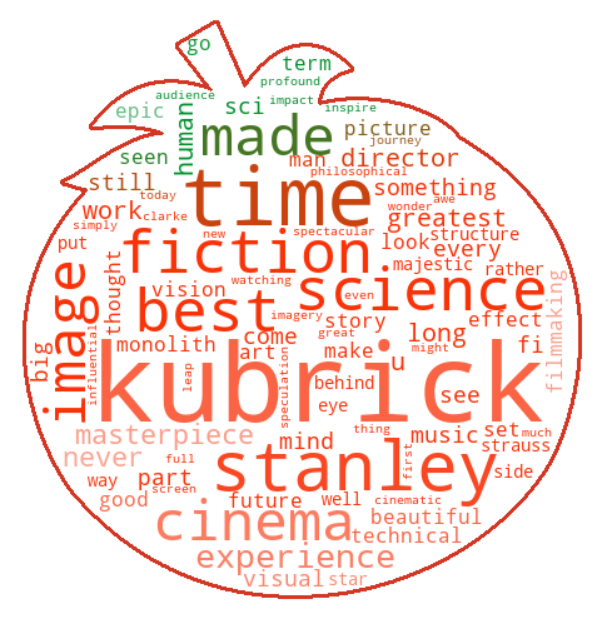

In [6]:
# Ready tomato image (add white background by pasting original image over a blank white image) 
transparent_image = Image.open('Rotten_Tomatoes.png')
white_background_image = Image.new("RGBA", transparent_image.size, "WHITE")
white_background_image.paste(transparent_image, (0, 0), transparent_image)
outline_image = white_background_image.convert('RGB')

# Create word cloud
mask = np.array(outline_image)
colors = ImageColorGenerator(mask)
wordcloud = WordCloud(background_color='white', color_func=colors, min_font_size=10, mask=mask, contour_color='#D33623', contour_width=2,
                      collocations=False).generate(" ".join(words))
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('review_snippet_word_cloud.png', format='png')
plt.show()